In [1]:
import numpy as np
import xarray as xr
from modules.ADI import ADI
from modules.classes import Quantity2D, Analytic, Interpolate
from modules.integrator import forward_euler_final
from modules.tests import plot_mass_conservation, calculate_boundary_flux, integrate_concentration
from modules.functions import animate
import matplotlib.pyplot as plt
from modules.tests import test_gaussian
import xarray as xr

ModuleNotFoundError: No module named 'soil_geometry'

# Boundary Conditions Test

In [2]:
test_int1, test_analytic1 = test_gaussian(ADI, BC='dirichlet')
diff1 = test_int1 - test_analytic1


Text(0.5, 1.0, 'Dirichlet')

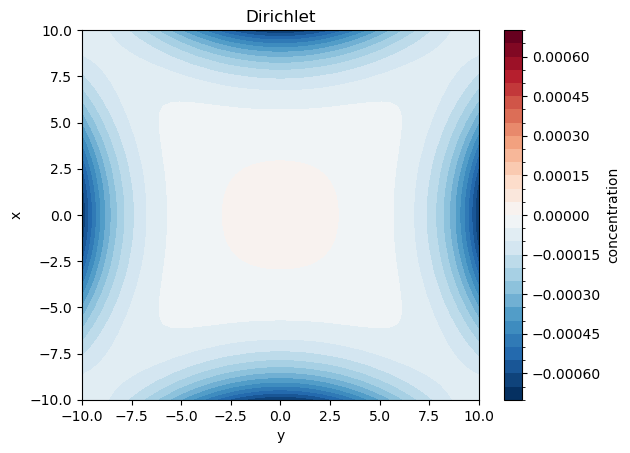

In [45]:
xr.plot.contourf(diff1.isel(t=900), levels=30)
plt.title('Dirichlet')

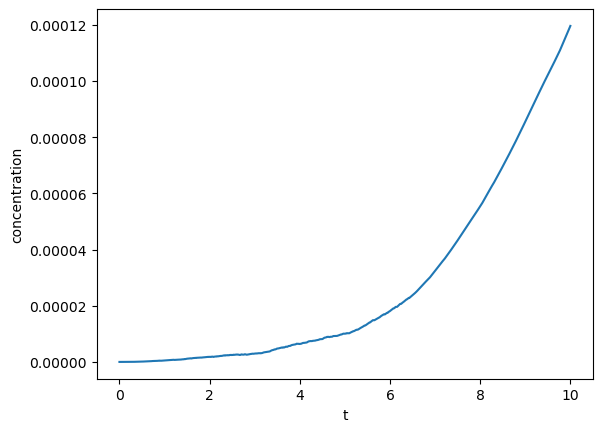

In [4]:
absdiff1 = np.absolute(diff1)
absdiff1.median(dim=('x','y')).plot()

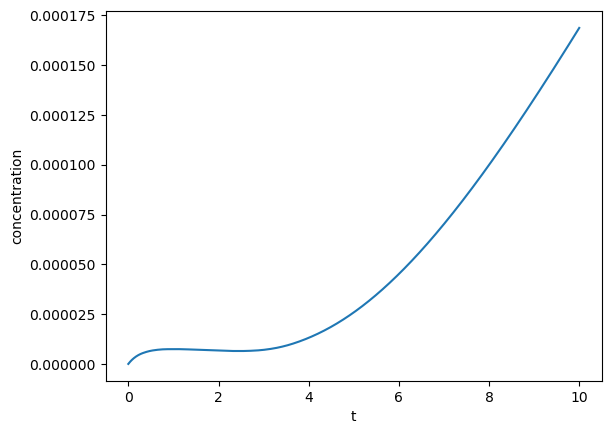

In [5]:
absdiff1.mean(dim=('x','y')).plot()

In [6]:
test_int2, test_analytic2 = test_gaussian(ADI, BC='neumann') # Time to check whether the neumann conditions are correct
diff2 = test_int2 - test_analytic2

Text(0.5, 1.0, 'Neumann')

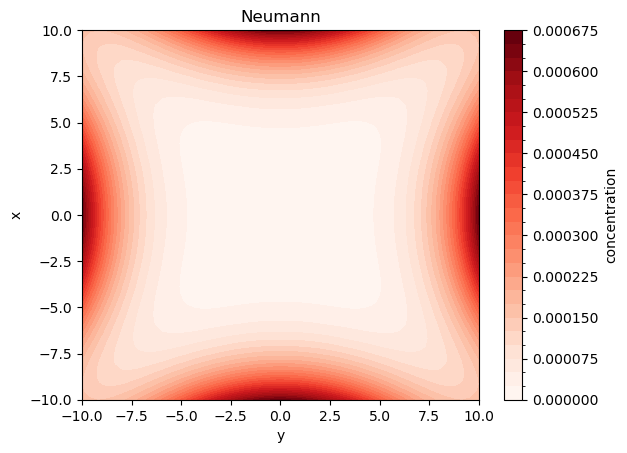

In [46]:
xr.plot.contourf(diff2.isel(t=900), levels=30, cmap='Reds')
plt.title('Neumann')

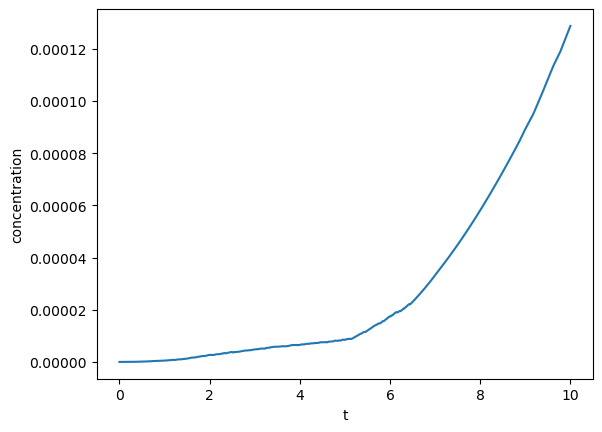

In [8]:
absdiff2 = np.absolute(diff2)
absdiff2.median(dim=('x','y')).plot()

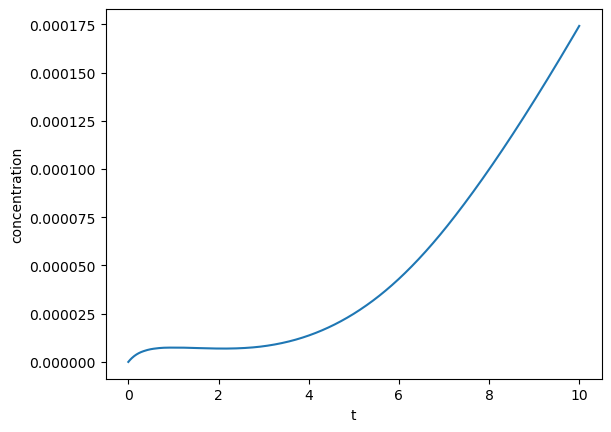

In [9]:
absdiff2.mean(dim=('x','y')).plot()

In [10]:
test_int3, test_analytic3 = test_gaussian(ADI, BC='open')
diff3 = test_int3 - test_analytic3

Text(0.5, 1.0, 'Pseudo-Open')

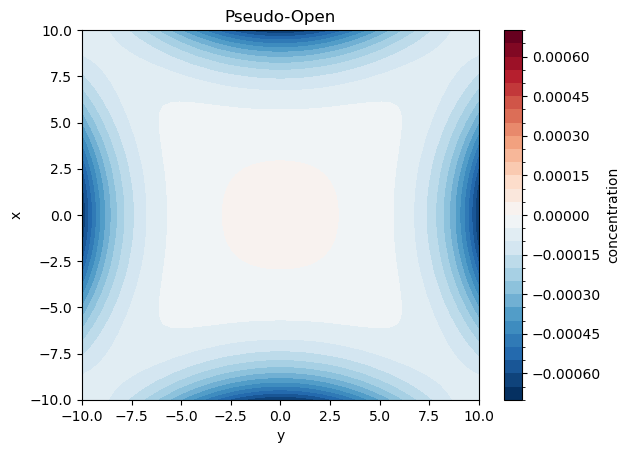

In [47]:
xr.plot.contourf(diff3.isel(t=900), levels=30)
plt.title('Pseudo-Open')

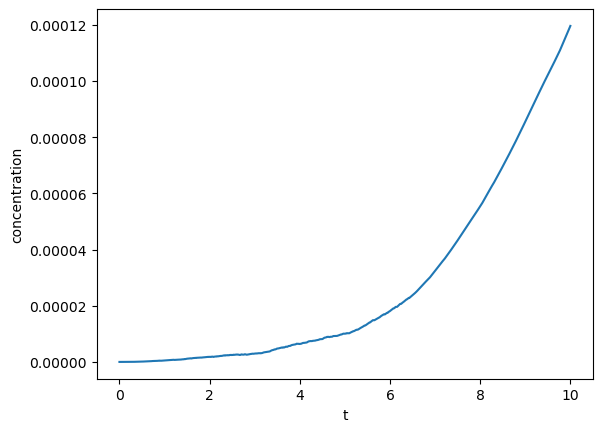

In [12]:
absdiff3 = np.absolute(diff3)
absdiff3.median(dim=('x','y')).plot()

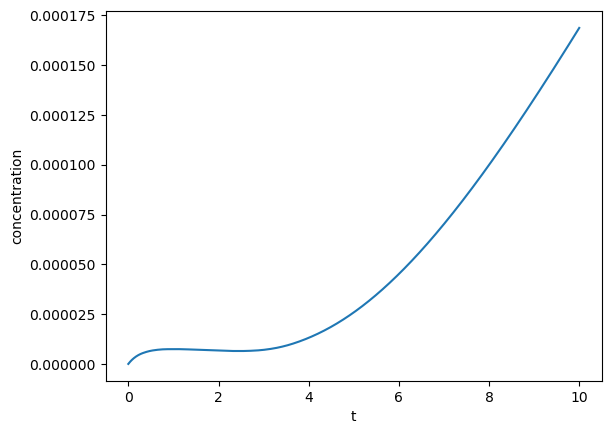

In [13]:
absdiff3.mean(dim=('x','y')).plot()

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\65948\AppData\Local\Temp\ipykernel_8652\2967848017.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$ concentration")


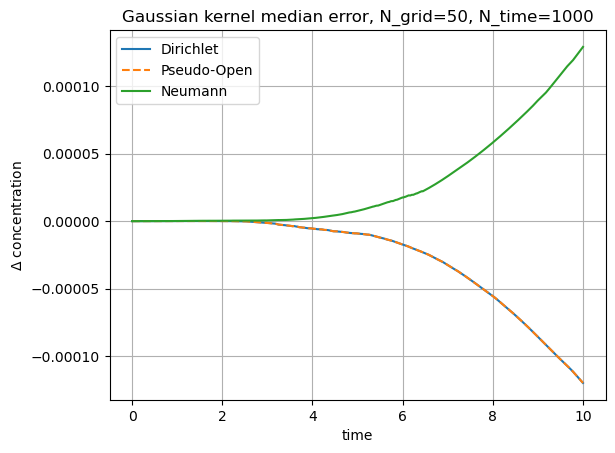

In [42]:
# Overlapped plots
data1 = diff1.median(dim=('x','y'))
data2 = diff2.median(dim=('x','y'))
data3 = diff3.median(dim=('x','y'))
tcoords = data1.coords['t']
plt.plot(tcoords, data1, label = 'Dirichlet')
plt.plot(tcoords, data3, label = 'Pseudo-Open', linestyle='--')
plt.plot(tcoords, data2, label = 'Neumann')
plt.title("Gaussian kernel median error, N_grid=50, N_time=1000")
plt.ylabel("$\Delta$ concentration")
plt.xlabel("time")
plt.grid()
plt.legend()

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\65948\AppData\Local\Temp\ipykernel_8652\2810479613.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$ concentration")


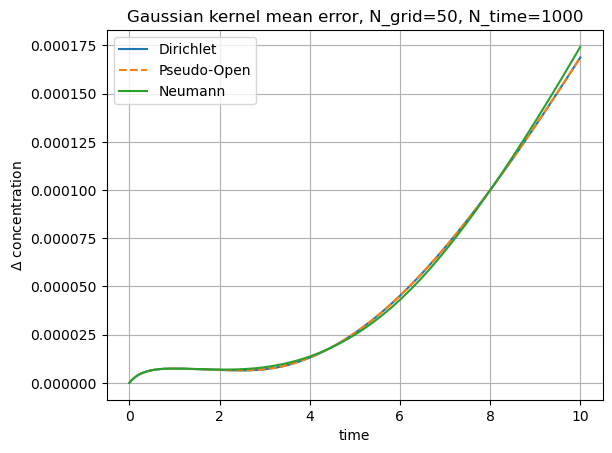

In [35]:
# Overlapped plots
data1 = absdiff1.mean(dim=('x','y'))
data2 = absdiff2.mean(dim=('x','y'))
data3 = absdiff3.mean(dim=('x','y'))
tcoords = data1.coords['t']
plt.plot(tcoords, data1, label = 'Dirichlet')
plt.plot(tcoords, data3, label = 'Pseudo-Open', linestyle='--')
plt.plot(tcoords, data2, label = 'Neumann')
plt.title("Gaussian kernel mean error, N_grid=50, N_time=1000")
plt.ylabel("$\Delta$ concentration")
plt.xlabel("time")
plt.grid()
plt.legend()

# FTCS vs. Crank-Nicholson ADI

In [14]:
test_int4, test_analytic4 = test_gaussian(forward_euler_final)
diff4 = test_int4 - test_analytic4


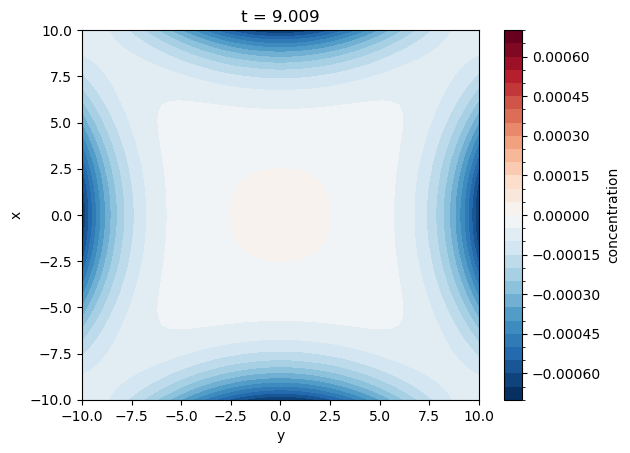

In [15]:
xr.plot.contourf(diff4.isel(t=900), levels=30)

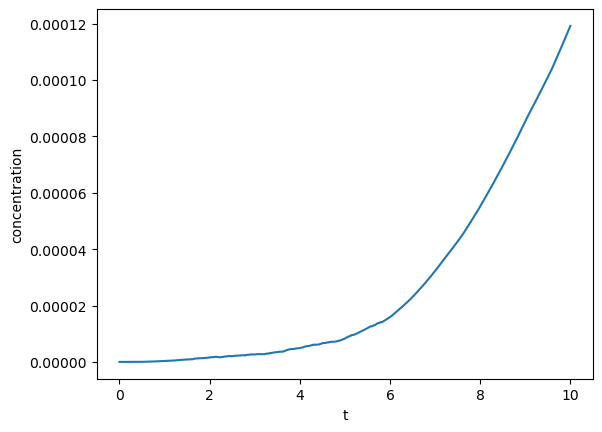

In [16]:
absdiff4 = np.absolute(diff4)
absdiff4.median(dim=('x','y')).plot()

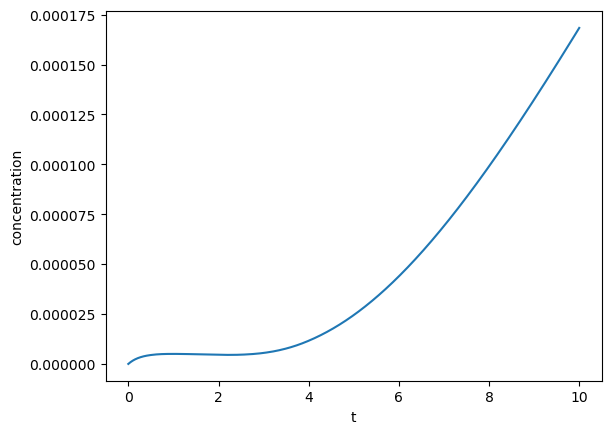

In [17]:
absdiff4.mean(dim=('x','y')).plot()

Text(0.5, 0.98, 'FTCS - CN, Gaussian IC, N_grid=50, timestep=900')

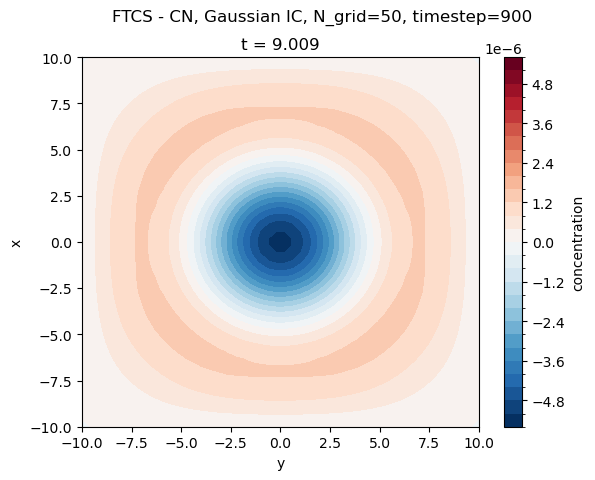

In [41]:
diff5 = test_int4 - test_int1
xr.plot.contourf(diff5.isel(t=900), levels=30)
plt.suptitle("FTCS - CN, Gaussian IC, N_grid=50, timestep=900")